# **ACT-CIFAR10-**

# Importing libraries

In [ ]:
#!pip install tensorflow==2.14.1

In [ ]:
#Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
import keras.layers as L
import keras.models as M
import keras.initializers as I
import keras.backend as K
from keras import optimizers
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import cv2,os
from PIL import Image, ImageOps
from google.colab.patches import cv2_imshow
import csv
import math
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix , classification_report,accuracy_score, ConfusionMatrixDisplay, recall_score
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.datasets import cifar10

In [ ]:
img_size=32

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

y_train = to_categorical(y_train, 10) # CIFAR-10 has 10 classes
y_test = to_categorical(y_test, 10)


print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

170498071/170498071 [==============================] - 19s 0us/step
x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 10)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 10)


In [ ]:
#Define the range of batch size for network
def find_factors(n):
    factors = []
    for i in range(1, n + 1):
        if n % i == 0:
            factors.append(i)
    return factors


print(find_factors(x_train.shape[0]))

[1, 2, 4, 5, 8, 10, 16, 20, 25, 40, 50, 80, 100, 125, 200, 250, 400, 500, 625, 1000, 1250, 2000, 2500, 3125, 5000, 6250, 10000, 12500, 25000, 50000]


In [ ]:
# Makign the squash function
def squash(vectors, axis=-1):
    squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
    scale = squared_norm / (1 + squared_norm) / (K.sqrt(squared_norm) + K.epsilon())
    return scale * vectors

In [ ]:
from keras.applications.densenet import DenseNet201
from keras.layers import (Input, Conv2D, BatchNormalization, ReLU, Dense, AveragePooling2D, Concatenate, GlobalAveragePooling2D, Multiply, Conv2DTranspose)

In [ ]:
from keras.src.layers import MaxPooling2D
from keras.src.layers.regularization.dropout import Dropout
batch_size = 100

img_shape = (img_size, img_size, 3)

# # Define a custom input layer with a hardcoded batch size
input_layer = L.Input(batch_shape=(batch_size,) + img_shape)


from keras.layers import DepthwiseConv2D, GlobalAveragePooling2D, Reshape, Multiply

def powerfeature(input_layer, num_layers, expansion_factor, reduction_factor=0.9):

    # x = L.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    # x = L.Dropout(0.2)(x)
    # x = L.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    # x = L.MaxPooling2D((2, 2))(x)

    x = L.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(input_layer)
    x = L.Dropout(0.2)(x)
    x = L.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    x = L.MaxPooling2D((2, 2))(x)

    x = L.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    x = L.Dropout(0.3)(x)
    x = L.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    x = L.MaxPooling2D((2, 2))(x)


    for _ in range(num_layers):
        x1 = L.Conv2D(2 * expansion_factor, (3, 3), kernel_initializer='he_normal', padding='same')(x)
        x1 = L.Dropout(0.2)(x1)
        x1 = L.Conv2D(expansion_factor, (3, 3), kernel_initializer='he_normal', padding='same')(x1)
        x = L.Concatenate()([x, x1])


    # Attention Mechanism
    attention = GlobalAveragePooling2D()(x)
    attention = Reshape((1, 1, K.int_shape(x)[-1]))(attention)
    attention = L.Conv2D(K.int_shape(x)[-1] // 16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(attention)
    attention = L.Conv2D(K.int_shape(x)[-1], (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(attention)
    x = Multiply()([x, attention])


 # Transition Mechanism
    contracted_filters = int(K.int_shape(x)[-1] * reduction_factor)

    x = L.Conv2D(contracted_filters, (3, 3), kernel_initializer='he_normal', padding='same')(x)
    x = L.Dropout(0.5)(x)
    x = L.Conv2D(contracted_filters, (3, 3), kernel_initializer='he_normal', padding='same')(x)
    x = L.MaxPooling2D((2, 2))(x)

    return x


x = powerfeature(input_layer,num_layers=2, expansion_factor=4)



#Primary Capsule Layer
conv2 = L.Conv2D(filters=8 * 16, kernel_size=(3, 3), strides=(2, 2), padding='same')(x)
reshape2 = L.Reshape([-1, 8])(conv2)  # Reduce dimensions here
squashed_output = L.Lambda(squash)(reshape2)


In [ ]:
# Making capsule layer from scratch
class CapsuleLayer(L.Layer):
    def __init__(self, num_capsule, dim_capsule, routing=3, kernel_initializer='glorot_uniform', **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routing = routing
        self.kernel_initializer = kernel_initializer

    def build(self, input_shape):
        assert len(input_shape) >= 3
        self.input_num_capsule = input_shape[1]
        self.input_dim_capsule = input_shape[2]

        # transforming the matrix
        self.W = self.add_weight(
            shape=[self.num_capsule, self.input_num_capsule, self.dim_capsule, self.input_dim_capsule],
            initializer=self.kernel_initializer, name='w')
        self.built = True

    def call(self, inputs, training=None):
        input_expand = tf.expand_dims(tf.expand_dims(inputs, 1), -1)
        inputs_tiled = K.tile(input_expand, [1, self.num_capsule, 1, 1, 1])
        input_hat = tf.squeeze(tf.map_fn(lambda x: tf.matmul(self.W, x), elems=inputs_tiled))
        # b = tf.zeros(shape=[inputs.shape[0], self.num_capsule, 1, self.input_num_capsule])
        b = tf.zeros(shape=[tf.shape(inputs)[0], self.num_capsule, 1, self.input_num_capsule])

        assert self.routing > 0
        for i in range(self.routing):
            c = tf.nn.softmax(b, axis=1)
            output = squash(tf.matmul(c, input_hat))
            if i < self.routing - 1:
                b += tf.matmul(output, input_hat, transpose_b=True)
        return tf.squeeze(output)

    def compute_output_shape(self, input_shape):
        return tuple([None, self.num_capsule, self.dim_capsule])

    def get_config(self):
        config = {
            'num_capsule': self.num_capsule,
            'dim_capsule': self.dim_capsule,
            'routings': self.routings
        }
        base_config = super(CapsuleLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [ ]:
aeccaps = CapsuleLayer(num_capsule=10, dim_capsule=8, routing=3, name='aeccaps')(squashed_output)

In [ ]:
# Making length layer which will calculate the length of the vectors
class Length(L.Layer):
    def call(self, inputs, **kwargs):
        return tf.sqrt(tf.reduce_sum(tf.square(inputs), -1))

    def compute_output_shape(self, input_shape):
        return input_shape[:-1]

    def get_config(self):
        config = super(Length, self).get_config()
        return config


In [ ]:
# Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
# If using tensorflow, this will not be necessary. :)
out_caps = Length(name='capsnet')(aeccaps)

In [ ]:
# Making the masking layer
class Mask(L.Layer):
    def call(self, inputs, **kwargs):
        if type(inputs) is list:
            assert len(inputs) == 2
            inputs, mask = inputs
        else:
            x = tf.sqrt(tf.reduce_sum(tf.square(inputs), -1))
            mask = tf.one_hot(indices=tf.argmax(x, 1), depth=x.shape[1])
        masked = K.batch_flatten(inputs * tf.expand_dims(mask, -1))
        return masked

    def compute_output_shape(self, input_shape):
        if type(input_shape[0]) is tuple:  # true label provided
            return tuple([None, input_shape[0][1] * input_shape[0][2]])
        else:  # no true label provided
            return tuple([None, input_shape[1] * input_shape[2]])

    def get_config(self):
        config = super(Mask, self).get_config()
        return config

In [ ]:
y = L.Input(shape=(10,))
print(y.shape)
print(aeccaps.shape)
masked_by_y = Mask()([aeccaps, y])  # The true label is used to mask the output of capsule layer. For training
print(masked_by_y.shape)
masked = Mask()(aeccaps)
print(masked.shape)

(None, 10)
(100, 10, 8)
(100, 80)
(100, 80)


In [ ]:
input_shape = x_train.shape[1:]
decoder = M.Sequential(name='decoder')
decoder.add(L.Dense(512, activation='relu',kernel_initializer='he_normal', input_dim=8 * 10))
decoder.add(L.Dense(1024, activation='relu',kernel_initializer='he_normal'))
decoder.add(L.Dense(img_size * img_size * 3, activation='softmax'))
decoder.add(L.Reshape(target_shape=input_shape, name='out_recon'))


In [ ]:
# Making models
train_model = M.Model([input_layer, y], [out_caps, decoder(masked_by_y)])
eval_model = M.Model(input_layer, [out_caps, decoder(masked)])

In [ ]:
# Making the loss function
def margin_loss(y_true, y_pred):
    L = y_true * tf.square(tf.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * tf.square(tf.maximum(0., y_pred - 0.1))
    return tf.reduce_mean(tf.reduce_sum(L, 1))

In [ ]:
train_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(100, 32, 32, 3)]           0         []                            
                                                                                                  
 conv2d (Conv2D)             (100, 32, 32, 32)            896       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (100, 32, 32, 32)            0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (100, 32, 32, 32)            9248      ['dropout[0][0]']             
                                                                                              

In [ ]:
train_model.save_weights('/content/drive/MyDrive/models/yasir-CIFAR10-ACT_model_NoAug.weights.h5')
train_model.load_weights('/content/drive/MyDrive/models/yasir-CIFAR10-ACT_model_NoAug.weights.h5')


In [ ]:
n_samples = 5

In [ ]:
# plt.figure(figsize=(n_samples * 2, 3))
# for index in range(n_samples):
#     plt.subplot(1, n_samples, index + 1)
#     sample_image = x_test[index]
#     plt.imshow(sample_image, cmap="binary")
#     plt.title("Label:" + str(y_test[index]))
#     plt.axis("off")

# plt.show()

In [ ]:
m = batch_size
epochs = 100
# Using EarlyStopping, end training when val_accuracy is not improved for 10 consecutive times
early_stopping = keras.callbacks.EarlyStopping(monitor='val_capsnet_accuracy', mode='max',
                                               patience=2, restore_best_weights=True)


In [ ]:
print(x_train.shape)  # should be (num_samples, 28, 28, 1) or something similar
print(y_train.shape)  # should be (num_samples, 3) given your model summary
print(x_test.shape)   # should be (num_test_samples, 28, 28, 1) or similar
print(y_test.shape)   # should be (num_test_samples, 3)


(50000, 32, 32, 3)
(50000, 10)
(10000, 32, 32, 3)
(10000, 10)


In [ ]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_capsnet_accuracy', mode='max', factor=0.5, patience=4)
train_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999), loss=[margin_loss, 'mse'], loss_weights=[1., 0.0005],
                    metrics=['accuracy'])

history= train_model.fit([x_train, y_train], [y_train, x_train], batch_size=m, epochs=epochs,
                validation_data=([x_test, y_test], [y_test, x_test])
                # , callbacks=[early_stopping, lr_scheduler]
                )


Epoch 1/100
500/500 [==============================] - 106s 205ms/step - loss: 0.4509 - capsnet_loss: 0.4507 - decoder_loss: 0.2871 - capsnet_accuracy: 0.3056 - decoder_accuracy: 0.3342 - val_loss: 0.3759 - val_capsnet_loss: 0.3758 - val_decoder_loss: 0.2899 - val_capsnet_accuracy: 0.4170 - val_decoder_accuracy: 0.3345
Epoch 2/100
500/500 [==============================] - 99s 197ms/step - loss: 0.3392 - capsnet_loss: 0.3391 - decoder_loss: 0.2871 - capsnet_accuracy: 0.4852 - decoder_accuracy: 0.3346 - val_loss: 0.2927 - val_capsnet_loss: 0.2925 - val_decoder_loss: 0.2899 - val_capsnet_accuracy: 0.5663 - val_decoder_accuracy: 0.3347
Epoch 3/100
500/500 [==============================] - 98s 195ms/step - loss: 0.2778 - capsnet_loss: 0.2777 - decoder_loss: 0.2871 - capsnet_accuracy: 0.5864 - decoder_accuracy: 0.3348 - val_loss: 0.2544 - val_capsnet_loss: 0.2543 - val_decoder_loss: 0.2899 - val_capsnet_accuracy: 0.6241 - val_decoder_accuracy: 0.3349
Epoch 4/100
500/500 [==================

In [ ]:
evaluation_results = train_model.evaluate([x_test, y_test], [y_test, x_test], batch_size=m, verbose=0)
# print("Test Loss:", evaluation_results[0])
# print("Test Accuracy:", evaluation_results[3])

test_loss = evaluation_results[1]
test_accuracy = evaluation_results[3]

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Test Loss: 0.1327
Test Accuracy: 83.48%


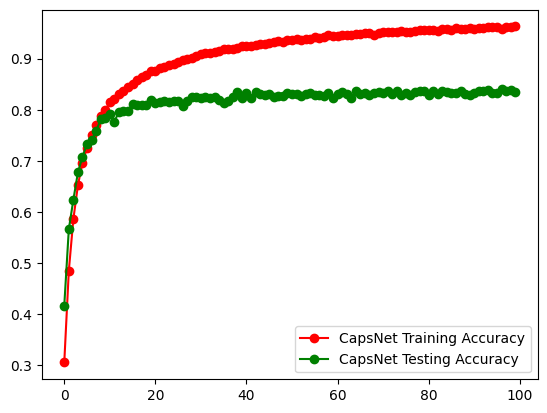

In [ ]:
plt.plot(history.history["capsnet_accuracy"] , 'ro-' , label = "CapsNet Training Accuracy")
plt.plot(history.history["val_capsnet_accuracy"] , 'go-' , label = "CapsNet Testing Accuracy")
plt.legend()
plt.show()

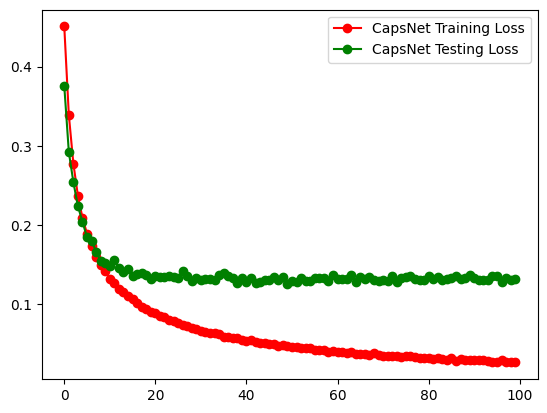

In [ ]:
plt.plot(history.history["capsnet_loss"] , 'ro-' , label = "CapsNet Training Loss")
plt.plot(history.history["val_capsnet_loss"] , 'go-' , label = "CapsNet Testing Loss")
plt.legend()
plt.show()